# Super.FELT using Reported Optimum Hyperparameters

The following code is an interpretation of the Super.FELT algorithm as presented in the paper
[Super.FELT: supervised feature extraction learning using triplet loss for drug response prediction with multi-omics data][1] 
by Park, S., Soh, J. & Lee, H. (2021) using the superfelt package provided in this repository 
based on the code available in [Super_FELT_main.py][2] from the Super.FELT GitHub repository.

[1]: https://doi.org/10.1186/s12859-021-04146-z
[2]: https://github.com/DMCB-GIST/Super.FELT/blob/main/Super_FELT_main.py

In [1]:
import moli
import superfelt

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

import torch
from torch.nn.functional import binary_cross_entropy
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})

## Drug Response Data

The drug response data was downloaded from the [Super.FELT Zenodo repository Version 2][3].
The GDSC response data was not provided in the repository and generated from the original
sources provided in the [MOLI GitHub repository annotations notebook][4]. The reported
optimal hyperparameter set (reported hp) and reported testing set AUC (reported auc) is
taken from [Table S27 of the original paper][5].


[3]: https://doi.org/10.5281/zenodo.4895679
[4]: https://github.com/hosseinshn/MOLI/blob/master/preprocessing_scr/annotations.ipynb
[5]: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04146-z#additional-information

In [2]:
zenodo_dir = './data/4895679'

In [3]:
study_sets = pd.DataFrame([
    ['PDX', '5-Fluorouracil', 'GDSC', 0, 0.865],
    ['PDX', 'Cetuximab', 'GDSC', 3, 0.636],
    ['PDX', 'Erlotinib', 'GDSC', 4, 0.742],
    ['PDX', 'Gemcitabine', 'GDSC', 0, 0.682],
    ['PDX', 'Paclitaxel', 'GDSC', 7, 0.72],
    ['PDX', 'Trametinib', 'GDSC', 3, 0.555],
    ['TCGA', '5-Fluorouracil', 'GDSC', 1, 0.493],
    ['TCGA', 'Cetuximab', 'GDSC', 7, 0.353],
    ['TCGA', 'Cisplatin', 'GDSC', 0, 0.759],
    ['TCGA', 'Docetaxel', 'GDSC', 4, 0.611],
    ['TCGA', 'Doxorubicin', 'GDSC', 0, 0.51],
    ['TCGA', 'Erlotinib', 'GDSC', 3, 0.85],
    ['TCGA', 'Etoposide', 'GDSC', 5, 0.02],
    ['TCGA', 'Gemcitabine', 'GDSC', 4, 0.634],
    ['TCGA', 'Mitomycin C', 'GDSC', 0, 0.64],
    ['TCGA', 'Paclitaxel', 'GDSC', 4, 0.529],
    ['TCGA', 'Sorafenib', 'GDSC', 0, 0.818],
    ['TCGA', 'Tamoxifen', 'GDSC', 5, 0.758],
    ['TCGA', 'Temozolomide', 'GDSC', 0, 0.634]
], columns = ['testing set', 'drug', 'training set', 'reported hp', 'reported auc'])
study_sets

,testing set,drug,training set,reported hp,reported auc
0,PDX,5-Fluorouracil,GDSC,0,0.865
1,PDX,Cetuximab,GDSC,3,0.636
2,PDX,Erlotinib,GDSC,4,0.742
3,PDX,Gemcitabine,GDSC,0,0.682
4,PDX,Paclitaxel,GDSC,7,0.720
5,PDX,Trametinib,GDSC,3,0.555
6,TCGA,5-Fluorouracil,GDSC,1,0.493
7,TCGA,Cetuximab,GDSC,7,0.353
8,TCGA,Cisplatin,GDSC,0,0.759
9,TCGA,Docetaxel,GDSC,4,0.611


## Hyperparameter selection

The Super.FELT analysis selected optimal hyperparameters for each dataset from eight empirically 
constructed hyperparameter sets. These are available in [Tables S6 and S7 of the original paper][5] 
and accessible through function `superfelt.utils.hyperparameter_tuning_sets()`.

Due to the small size of test sets, and small total training epochs, the prediction of the resulting 
networks can vary greatly. A total of 100 replicates was performed for each of the study sets in order 
to observe the distribution of test AUCs.

[5]: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04146-z#additional-information

In [4]:
%%capture output

replicates = 50
test_results = []
stdscaler = StandardScaler()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
hp_options = superfelt.utils.hyperparameter_tuning_sets()

for study_set in study_sets.to_dict('records'):
    ds = superfelt.utils.get_dataset(study_set['drug'], study_set['training set'], study_set['testing set'], zenodo_dir)
    hp = hp_options[study_set['reported hp']]
    # training set
    train_exp = stdscaler.fit_transform(ds['train']['expression'])
    train_exp = torch.FloatTensor(train_exp).to(device)
    train_mut = torch.FloatTensor(ds['train']['mutation']).to(device)
    train_cna = torch.FloatTensor(ds['train']['cna']).to(device)
    train_y = torch.FloatTensor(ds['train']['response']).to(device)
    # test set
    test_exp = stdscaler.transform(ds['test']['expression'])
    test_exp = torch.FloatTensor(test_exp).to(device)
    test_mut = torch.FloatTensor(ds['test']['mutation']).to(device)
    test_cna = torch.FloatTensor(ds['test']['cna']).to(device)
    test_y = torch.FloatTensor(ds['test']['response']).to(device)
    # Generate datasets
    train_dataset = torch.utils.data.TensorDataset(train_exp, train_mut, train_cna, train_y)
    train_dataloader = moli.utils.moli_dataloader(train_dataset, hp['batch_size'])
    test_dataset = torch.utils.data.TensorDataset(test_exp, test_mut, test_cna, test_y)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=hp['batch_size'])
    for ridx in range(replicates):
        net = superfelt.nn.SuperFeltNet(train_exp.shape[1], hp['exp_hl'], hp['exp_ep'],
                                        train_mut.shape[1], hp['mut_hl'], hp['cna_ep'],
                                        train_cna.shape[1], hp['cna_hl'], hp['cna_ep'],
                                        hp['enc_dr'], hp['cls_dr']).to(device)
        # Create optimizer
        optimizer = superfelt.optim.SuperFeltAdagrad(
            net, hp['enc_lr'], hp['enc_wd'], hp['cls_lr'], hp['cls_wd'])

        for ep in range(hp['epochs']):
            net.train()
            for i, (dataE, dataM, dataC, target) in enumerate(train_dataloader):
                if torch.mean(target) == 0. or torch.mean(target) == 1. or len(target)<=2:
                    continue
                enc_E, enc_M, enc_C, out = net(dataE, dataM, dataC)
                if torch.any(torch.isnan(out)).item():
                    break
                loss_E = moli.loss.moli_triplet_score(target, enc_E, hp['margin'])
                loss_M = moli.loss.moli_triplet_score(target, enc_M, hp['margin'])
                loss_C = moli.loss.moli_triplet_score(target, enc_C, hp['margin'])
                loss_CL = binary_cross_entropy(out, target.view(-1,1))
                optimizer.zero_grad()
                (loss_E + loss_M + loss_C + loss_CL).backward()
                optimizer.step()
        if torch.any(torch.isnan(out)).item():
            continue
        with torch.no_grad():
            net.eval()
            test_out = torch.tensor([], device=device)
            test_target = torch.tensor([], device=device)
            for dataE, dataM, dataC, target in test_dataloader:
                _, _, _, tout = net(dataE, dataM, dataC)
                test_out = torch.cat((test_out, tout), 0)
                test_target = torch.cat((test_target, target), 0)
            test_auc = roc_auc_score(test_target.cpu().detach().numpy(), test_out.cpu().detach().numpy())
            test_results.append({
                'drug': study_set['drug'], 'training set': study_set['training set'], 
                'testing set': study_set['testing set'], 'ridx': ridx, 'auc': test_auc
            })
test_df = pd.DataFrame(test_results)

## Results

The following is a plot of the observed test AUCs resulting from networks trained with the provided hyperparameters.
The reported AUC from the MOLI paper is displayed as a red X.

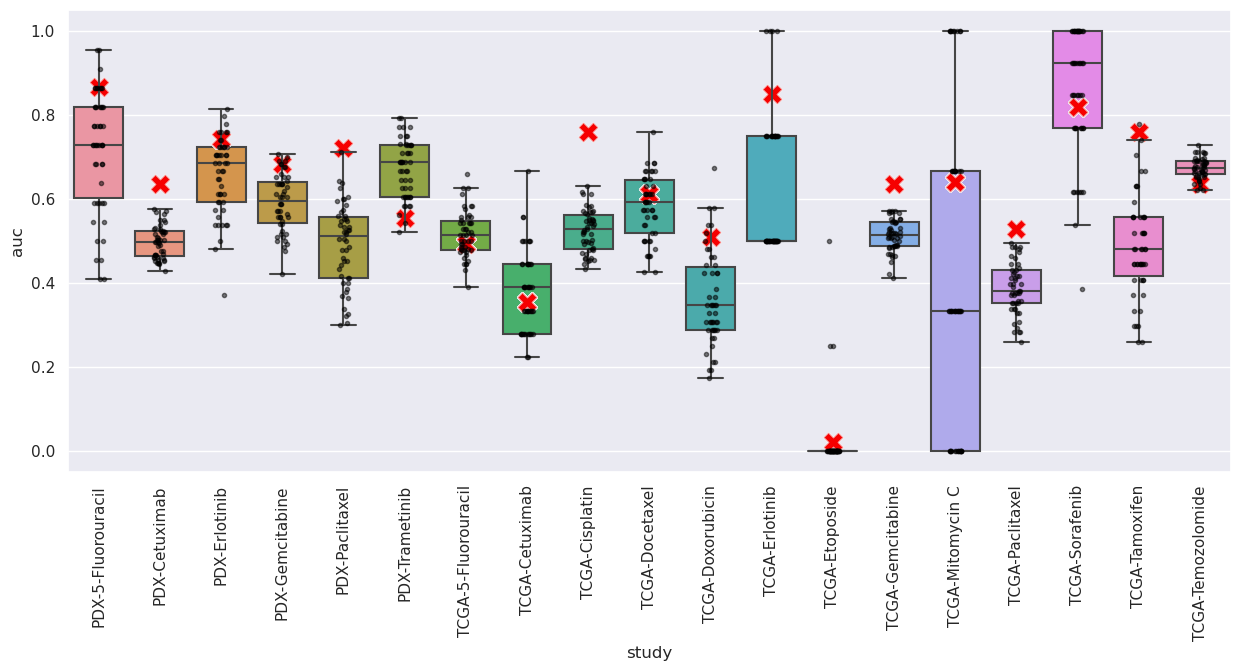

In [5]:
plot_df = test_df.merge(study_sets)
plot_df['study'] = plot_df['testing set'] + '-' + plot_df['drug']
ax = sns.boxplot(y='auc', x='study', data=plot_df, showfliers = False)
ax.tick_params(axis='x', labelrotation=90)
ax = sns.stripplot(y='auc', x='study', data=plot_df, color='black', s=3, axes=ax, alpha=0.5, linewidth=1.)
ax = sns.scatterplot(y='reported auc', x='study', data=plot_df, color='red', alpha=0.1, marker='X', s=200, axes=ax)

The maximum value between mean observed AUC and reported AUC is highlighed in green.
The 'within obs' column reports whether the reported AUC falls within the range of
observed AUCs. For five study sets, the reported AUC fell outside the range of 50 
observed replicant AUCs: PDX-Centuzimab, PDX-Paclitaxel, TCGA-Cisplatin, TCGA-Gemcitabine, 
and TCGA-Paclitaxel.

In [10]:
pd.set_option('display.precision', 3)
(test_df
 .groupby(['drug','training set','testing set'])
 .agg(**{"min auc": ('auc', 'min'), 'mean auc': ('auc', 'mean'), 'median auc': ('auc', 'median'), 'max auc': ('auc', 'max')})
 .reset_index()
 .merge(study_sets)
 .assign(**{"within obs": lambda x: (x['max auc'] >= x['reported auc']) & (x['min auc'] <= x['reported auc'])}, axis=1)
 .drop('axis', axis=1)
 .sort_values(['testing set', 'drug'])
 .style
 .highlight_max(subset = ['mean auc', 'reported auc'],color = 'lightgreen', axis = 1)
 .highlight_min(subset = ['within obs'], props='color:red', axis = 0)
 .format(precision=2)
)

,drug,training set,testing set,min auc,mean auc,median auc,max auc,reported hp,reported auc,within obs
0,5-Fluorouracil,GDSC,PDX,0.41,0.72,0.73,0.95,0,0.86,True
2,Cetuximab,GDSC,PDX,0.43,0.50,0.50,0.57,3,0.64,False
7,Erlotinib,GDSC,PDX,0.37,0.66,0.69,0.81,4,0.74,True
10,Gemcitabine,GDSC,PDX,0.42,0.59,0.60,0.71,0,0.68,True
13,Paclitaxel,GDSC,PDX,0.30,0.49,0.51,0.71,7,0.72,False
18,Trametinib,GDSC,PDX,0.52,0.67,0.69,0.79,3,0.56,True
1,5-Fluorouracil,GDSC,TCGA,0.39,0.52,0.51,0.66,1,0.49,True
3,Cetuximab,GDSC,TCGA,0.22,0.38,0.39,0.67,7,0.35,True
4,Cisplatin,GDSC,TCGA,0.43,0.52,0.53,0.63,0,0.76,False
5,Docetaxel,GDSC,TCGA,0.43,0.58,0.59,0.76,4,0.61,True
